INFO284 - Group assignment

# Common import statements

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import spacy
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from PIL import Image
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay,
                             accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, StratifiedGroupKFold,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder,
                                   MinMaxScaler, OneHotEncoder, StandardScaler)
from tensorflow.keras import Input, Model, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (LSTM, Concatenate, Conv2D, Dense, Dropout,
                                     Embedding, Input, MaxPooling2D)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from sklearn.naive_bayes import ComplementNB
from scipy.sparse import csr_matrix, hstack

# Common text

These comments are for all models (except CNN).
The dataset can be imbalanced, since half of the data are for scores above 8.8. A threshold (to 0 and 1) at around 9 could balance the dataset, but could also make it more difficult to separate categories close to the threshold. When many data points are grouped up, it therefore leads to a higher probability of misclassifications. The threshold has been set to 5.5 for all models, and as its closer to the middle it intuitively is something we can think of as either a low or high score. This therefore makes sense in terms of what the models will predict, where the lower scores are 0 and higher scores are 1. We will then have more data points of class 1. SMOTE or weights has been applied to deal with the imbalance, as it will create more data points for the minority class (0). Using the threshold also reduces dimensionality

# Task 1: LSTM

The model predicts hotel review scores using binary classification, based on numerical and text data. LSTM was chosen partly beause it excels at working with text data, and can handle multiple inputs.


## Preprocessing (LSTM)

1. Reducing dimensionality by using a threshold (see "COMMON TEXT") is important, considering the LSTM model is complex as it has both text and number inputs.
2. Weights was tested, but led to many misclassifications for this model.
3. Likely no NaNs in the dataset initially. errors="coerce" during conversion creates NaNs for error handling. Any rows with NaNs (likely few), will be dropped.
4. Feature selection:
    1. text_columns was chosen as they are crucial for this task, and LSTM models perform well with text.
    2. number_columns was included because they include important and relevant information.
    3. Features not included did not provide meaningful information, and could potentially cause noise.
5. Feature engineering:
    1. Text features are tokenized and padded, and the vocabulary is limited to 2000 words and each sequence has a fixed length of 450. This reduces the complexity/dimensionality of our problem. We therefore can avoid to use teqhnicues like one-hot encoding for the text data, which would be extremely inefficient for this model.
    2. Target Encoding has been applied to "Reviewer_Nationality", because it can calculate the mean for each value and therefore retaining meaningful information.
    3. Standardscaler has been applied, and is a common way to normalize values. This helps the model learn more effectively.

X_train_number_smote shape: (570652, 7)
X_test_number_numpy shape: (103148, 7)
X_train_text_smote shape: (570652, 450)
X_test_text_numpy shape: (103148, 450)
y_train_target_smote shape: (570652,)
y_test_target_numpy shape: (103148,)


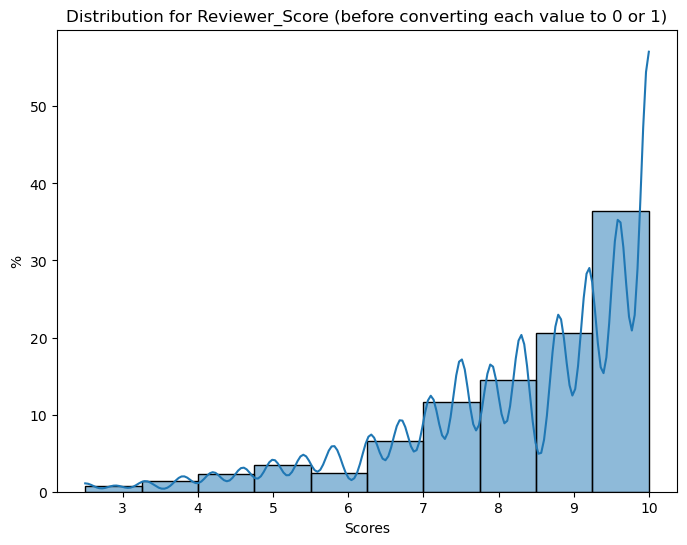

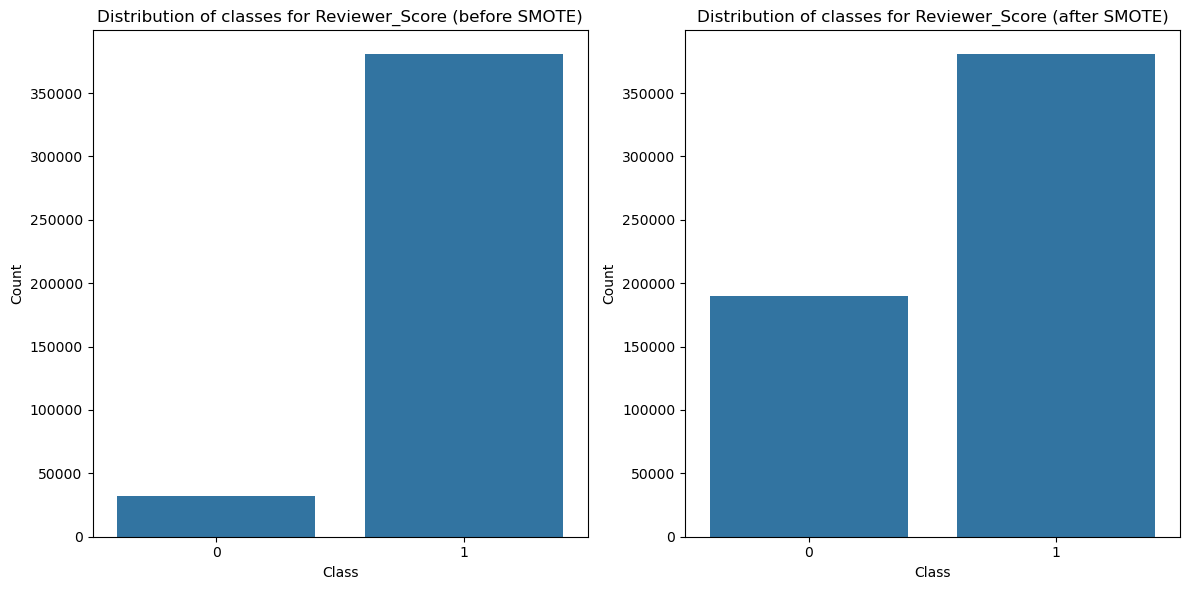

In [20]:
path = "Hotel_Reviews.csv"

number_columns = ["Additional_Number_of_Scoring",
              "Average_Score", "Review_Total_Negative_Word_Counts",
              "Total_Number_of_Reviews", "Review_Total_Positive_Word_Counts",
              "Total_Number_of_Reviews_Reviewer_Has_Given"]

text_columns = ["Negative_Review", "Positive_Review"]

target_feature = "Reviewer_Score" # to be predicted in the model

dataset = pd.read_csv(path, usecols=(number_columns + text_columns + [target_feature, "Reviewer_Nationality"]), low_memory=False)

# Plot variable (before conversion)
plot_1 = dataset[target_feature]

# Converts the values in target_feature to 0 or 1, values greater than 5.5 will be 1, and values below 5.5 will be 0
dataset[target_feature] = (dataset[target_feature] >= 5.5).astype("int")

# Converts string values in number_columns to numeric values (float or int)
for column in number_columns:
    dataset[column] = pd.to_numeric(dataset[column], errors="coerce")
dataset.dropna(inplace=True)

# Splitting the dataset into training and test sets
X = dataset.drop(columns=[target_feature])
y = dataset[target_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Target Encoding converts "Reviewer_Nationality" (countries -> strings) to numerical values by replacing each country with the mean
# "Reviewer_Score" for that country in the training data (y_train)
target_encoder = ce.TargetEncoder(cols=["Reviewer_Nationality"])
X_train["Reviewer_Nationality"] = target_encoder.fit_transform(X_train["Reviewer_Nationality"], y_train)
X_test["Reviewer_Nationality"] = target_encoder.transform(X_test["Reviewer_Nationality"], y_test)

# Text vectorization (text_columns = ["Negative_Review", "Positive_Review"])
max_features = 2000 # vocabulary size
length = 450
vectorizer = TfidfVectorizer(max_features=max_features)

X_train_text = [" ".join(text) for text in X_train[text_columns].to_numpy().astype(str)]
X_test_text = [" ".join(text) for text in X_test[text_columns].to_numpy().astype(str)]

X_train_text_vectorized = vectorizer.fit_transform(X_train_text)
X_test_text_vectorized = vectorizer.transform(X_test_text)

# Padding (so that all sequences have the same length) -> returns a Numpy Array
X_train_text_numpy = pad_sequences(X_train_text_vectorized.toarray(), maxlen=length, padding="post", truncating="post")
X_test_text_numpy = pad_sequences(X_test_text_vectorized.toarray(), maxlen=length, padding="post", truncating="post")

# StandardScaler adjusts the numbers in these columns (number_columns + "Reviewer_Nationality") so they're on a similar scale
scaler = StandardScaler()
X_train[number_columns + ["Reviewer_Nationality"]] = scaler.fit_transform(X_train[number_columns + ["Reviewer_Nationality"]])
X_test[number_columns + ["Reviewer_Nationality"]] = scaler.transform(X_test[number_columns + ["Reviewer_Nationality"]])

# Convert data to NumPy arrays (float32 = float num, int32 = integers), text_columns are already Numpy Arrays
X_train_number_numpy = X_train[number_columns + ["Reviewer_Nationality"]].to_numpy(dtype="float32")
X_test_number_numpy = X_test[number_columns + ["Reviewer_Nationality"]].to_numpy(dtype="float32")

y_train_target_numpy = y_train.to_numpy(dtype="int32")
y_test_target_numpy = y_test.to_numpy(dtype="int32")

# Plot variable (before SMOTE)
plot_3 = y_train_target_numpy

# SMOTE (number_columns + "Reviewer_Nationality", text_columns separately)
smote_number = SMOTE(random_state=20, sampling_strategy=0.5)
X_train_number_smote, y_train_target_smote = smote_number.fit_resample(X_train_number_numpy, y_train_target_numpy)

smote_text = SMOTE(random_state=20, sampling_strategy=0.5)
X_train_text_smote, y_train_target_smote = smote_text.fit_resample(X_train_text_numpy, y_train_target_numpy)

# Plot variable (after SMOTE)
plot_4 = y_train_target_smote

# Print shape (so that we know the model can receive it)
print("X_train_number_smote shape:", X_train_number_smote.shape)
print("X_test_number_numpy shape:", X_test_number_numpy.shape)
print("X_train_text_smote shape:", X_train_text_smote.shape)
print("X_test_text_numpy shape:", X_test_text_numpy.shape)
print("y_train_target_smote shape:", y_train_target_smote.shape)
print("y_test_target_numpy shape:", y_test_target_numpy.shape)

# Plot (before changing each value to 0 or 1)
plt.figure(figsize=(8, 6))
sns.histplot(plot_1, bins=10, kde=True, stat="percent")
plt.title("Distribution for Reviewer_Score (before converting each value to 0 or 1)")
plt.xlabel("Scores")
plt.ylabel("%")
plt.show()

# Plot (before and after SMOTE)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=plot_3)
plt.title("Distribution of classes for Reviewer_Score (before SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=plot_4)
plt.title("Distribution of classes for Reviewer_Score (after SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## Model (LSTM)


1. Architecture:
   1. The model has relatively few layers and neurons, which can prevent overfitting.
   2. Text input: Embedded and sent through an LSTM layer, and Dropout to prevent overfitting.
   3. Number input: Dense layers with relu activation to learn more complex patterns.
   4. Output: the inputs are concatenated, followed by more dense layers, before the final output is produced via the sigmoid activation function which returns one probability.
2. Training:
   1. .compile(): Binary-crossentropy suits the task of binary classification, and Adam optimizer is common and efficient for this task.
   2. .fit(): the model is trained on the SMOTE enhanced features, with 5 epochs which lets it train sufficiently on the data and at the same time not so much that it overfits. batch_size is also important.

Epoch 1/5
4459/4459 ━━━━━━━━━━━━━━━━━━━━ 579s 130ms/step - accuracy: 0.7749 - loss: 0.4758 - val_accuracy: 0.8451 - val_loss: 0.3308
Epoch 2/5
4459/4459 ━━━━━━━━━━━━━━━━━━━━ 595s 133ms/step - accuracy: 0.8002 - loss: 0.4297 - val_accuracy: 0.8576 - val_loss: 0.3312
Epoch 3/5
4459/4459 ━━━━━━━━━━━━━━━━━━━━ 577s 129ms/step - accuracy: 0.8032 - loss: 0.4238 - val_accuracy: 0.8604 - val_loss: 0.3385
Epoch 4/5
4459/4459 ━━━━━━━━━━━━━━━━━━━━ 587s 132ms/step - accuracy: 0.8042 - loss: 0.4195 - val_accuracy: 0.8651 - val_loss: 0.3197
Epoch 5/5
4459/4459 ━━━━━━━━━━━━━━━━━━━━ 587s 132ms/step - accuracy: 0.8049 - loss: 0.4185 - val_accuracy: 0.8534 - val_loss: 0.3510
17833/17833 ━━━━━━━━━━━━━━━━━━━━ 250s 14ms/step
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 450)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 450, 128)  │    256,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 450, 128)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 8)         │      4,384 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │         40 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8)         │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5)         │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 13)        │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5)         │         45 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          6 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 781,763 (2.98 MB)

 Trainable params: 260,587 (1017.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 521,176 (1.99 MB)

None


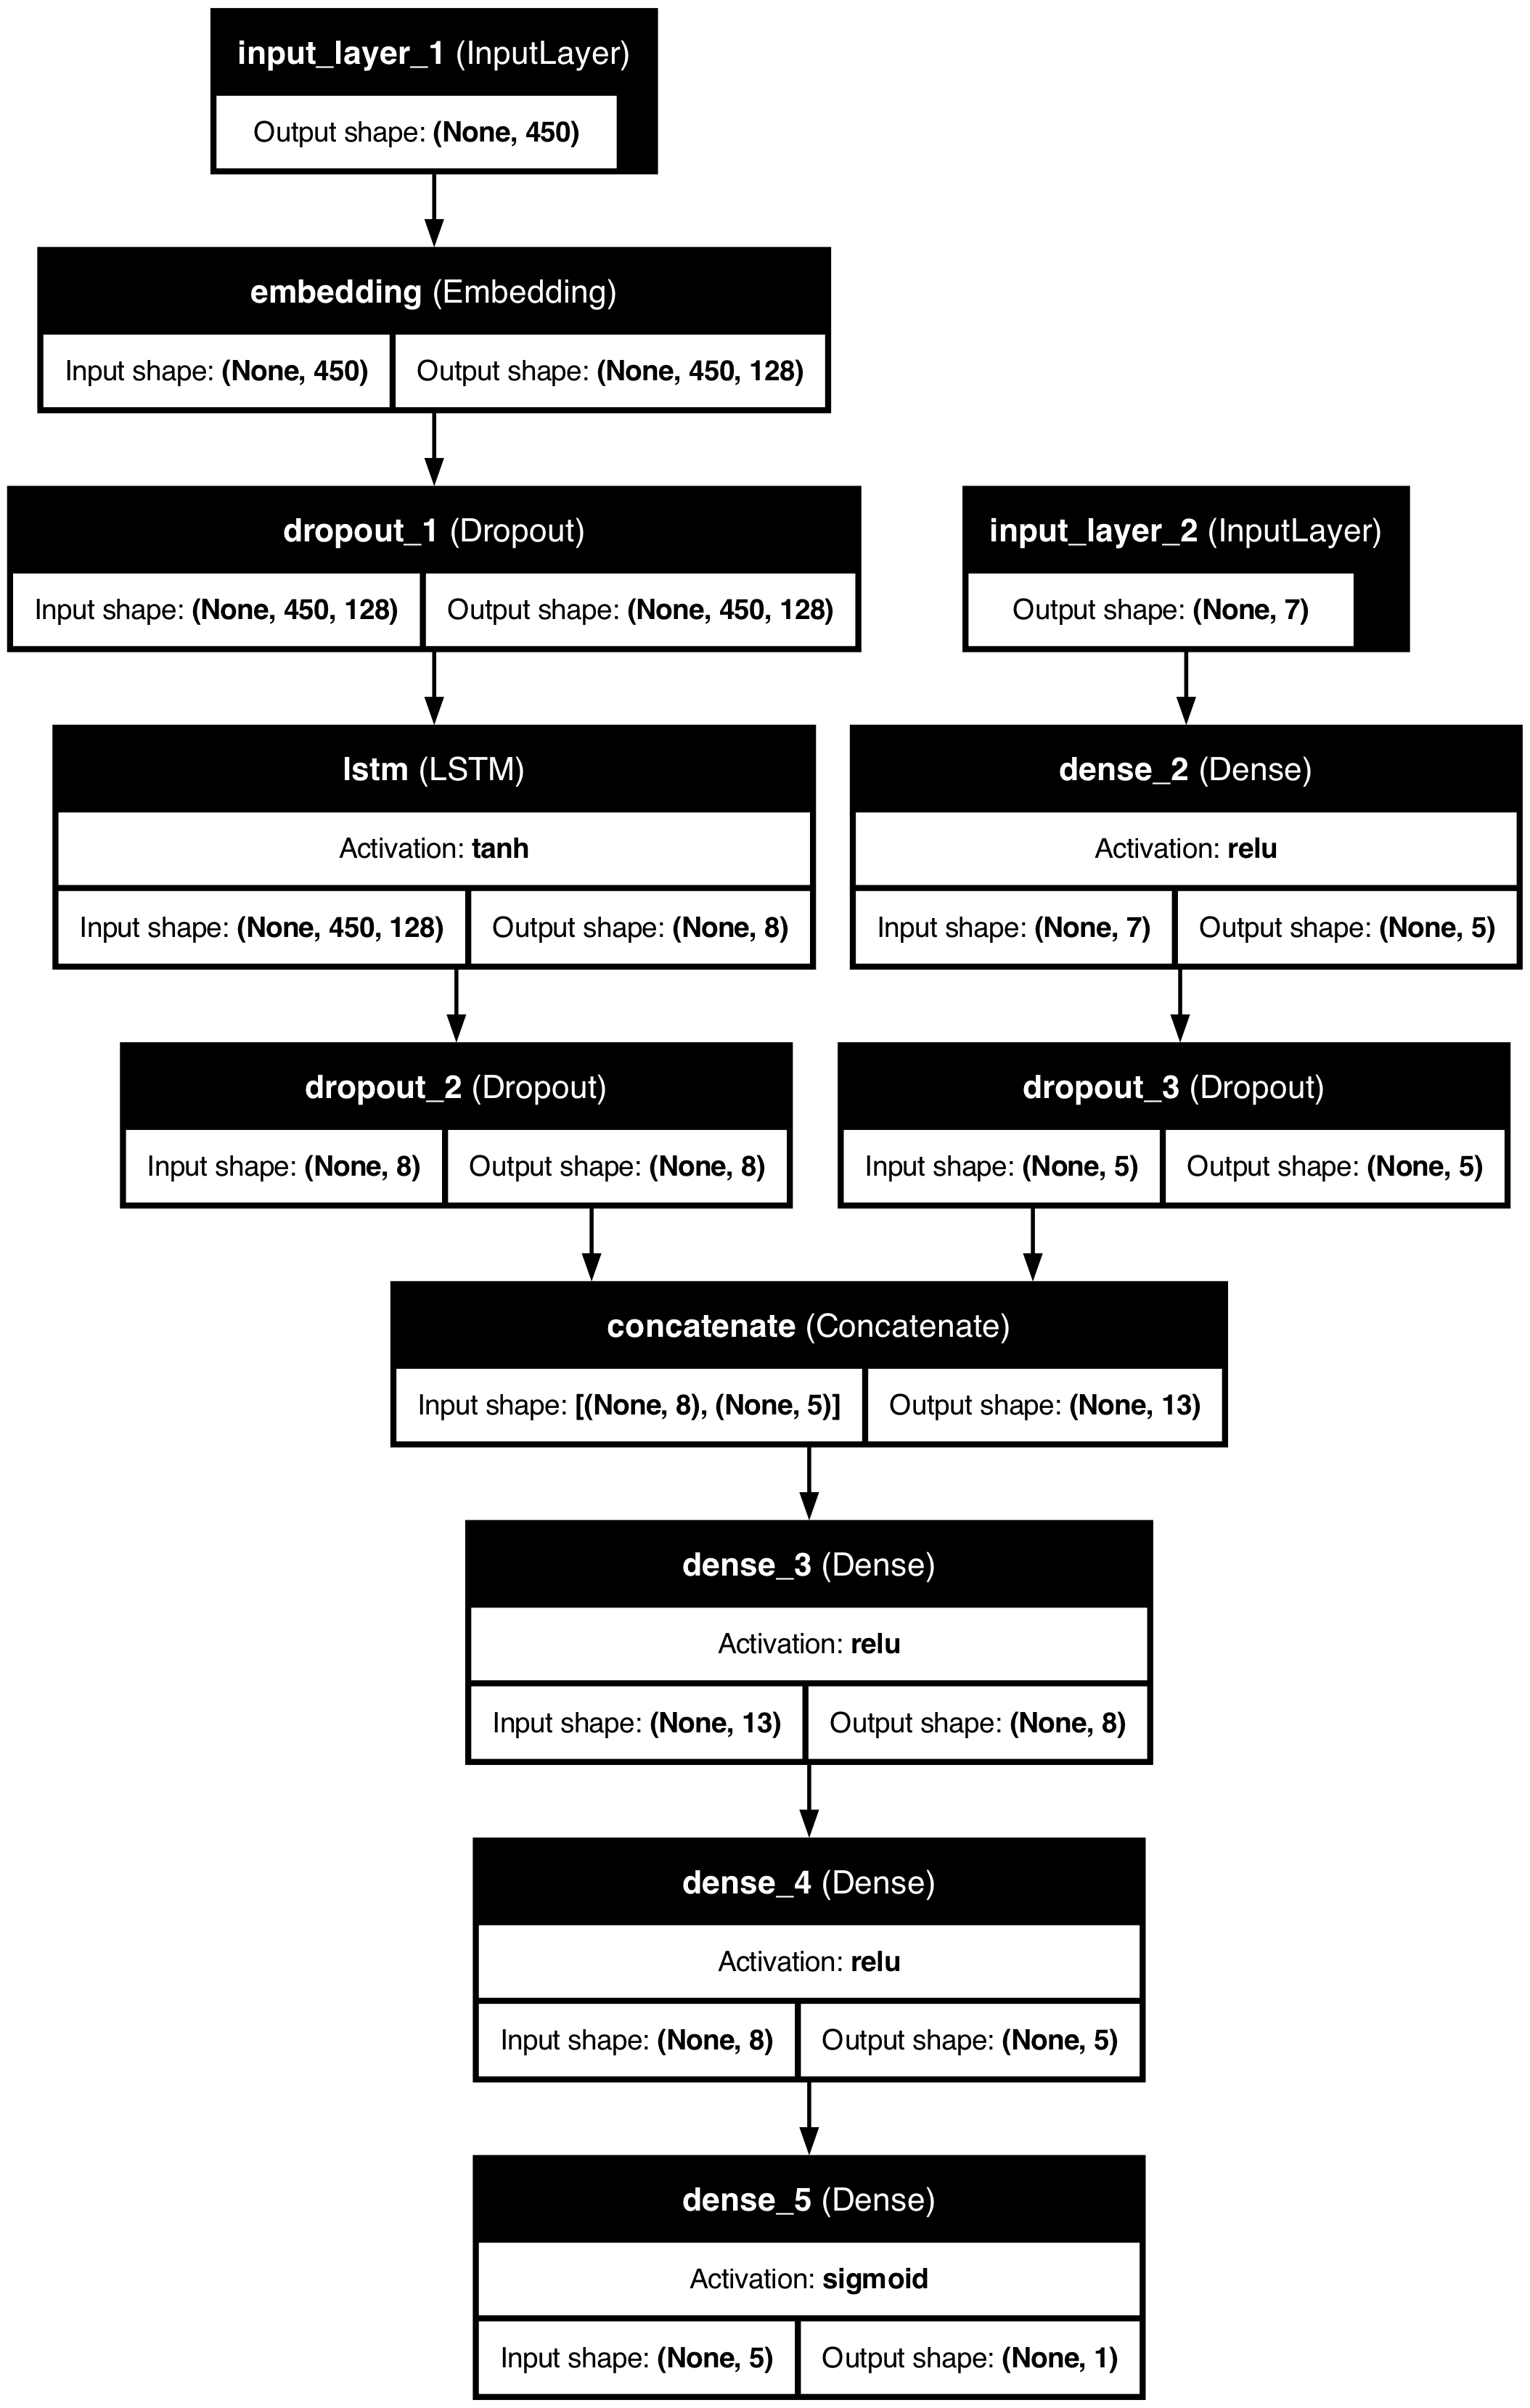

In [21]:
# First input (2 columns -> text_columns = ["Negative_Review", "Positive_Review"])
text = Input(shape=(length, ))
first_layer = Embedding(input_dim=max_features, output_dim=128)(text)
second_layer = Dropout(0.2)(first_layer)
third_layer = LSTM(8)(second_layer)
fourth_layer = Dropout(0.1)(third_layer)

# Second input (7 columns -> [number_columns, "Reviewer_Nationality"])
number = Input(shape=(7,))
fifth_layer = Dense(5, activation="relu")(number)
sixth_layer = Dropout(0.2)(fifth_layer)

# Concatenate first and second input, and then output (one neuron with sigmoid)
merging = Concatenate()([fourth_layer, sixth_layer])
seventh_layer = Dense(8, activation="relu")(merging)
eighth_layer = Dense(5, activation="relu")(seventh_layer)
ninth_layer = Dense(1, activation="sigmoid")(eighth_layer)

# Model: define and train
lstm = Model(inputs=[text, number], outputs=ninth_layer)
lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm.fit(
    [X_train_text_smote, X_train_number_smote],
    y_train_target_smote,
    batch_size=128,
    epochs=5,
    validation_data=([X_test_text_numpy, X_test_number_numpy], y_test_target_numpy)
)

# Predictions (between 0 and 1)
prediction_1 = lstm.predict([X_train_text_smote, X_train_number_smote])
prediction_2 = lstm.predict([X_test_text_numpy, X_test_number_numpy])

# Classification: Class 1 if prediction is > 0.5, class 0 if prediction is <= 0.5
classification_1 = [1 if probability > 0.5 else 0 for probability in prediction_1]
classification_2 = [1 if probability > 0.5 else 0 for probability in prediction_2]

# Summary + plot of architecture
print(lstm.summary())
plot_model(lstm,
           show_shapes=True,
           show_layer_names=True,
           show_layer_activations=True,
           expand_nested=True)

## Evaluation of the model (LSTM)


1. The training and test sets are evaluated separately to assess performance.

2. Of the chosen metrics we focus on F1-score and ROC-AUC, not accuracy, because of the class imbalance. High accuracy can be achieved even if class 0 is badly predicted, making accuracy a misleading metric. F1-score and ROC-AUC consider both correctly classified and misclassified data. F1-score balances precision and recall, which is important here. ROC-AUC measures the models ability to distinguish between classes. Because of this, these metrics are more useful for evaluating how good the model is in terms of generalization. The confusion matrix is useful for identifying misclassifications.

3. The test output shows a low F1-score for class 0 and high for class 1. This means the model has difficulties in classifying class 0, even though the ROC-AUC is fairly high. The high ROC-AUC indicates the model can distinguish between classes, but it still favors class 1. This leads to low precision for class 0, which means many class 0 data points were actually class 1.

4. Higher sampling_strategy values (0.6+) introduced noise which can cause overfitting, lowering the F1-score. Therefore 0.5 is chosen.

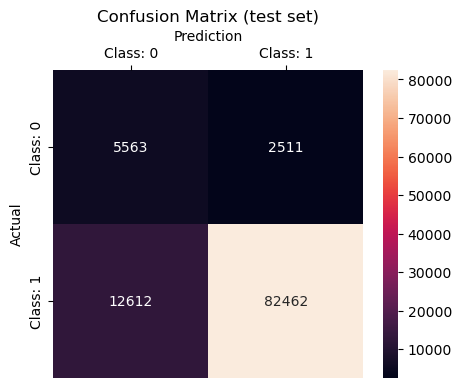

Classification report (test set):
               precision    recall  f1-score   support

    Class: 0       0.31      0.69      0.42      8074
    Class: 1       0.97      0.87      0.92     95074

    accuracy                           0.85    103148
   macro avg       0.64      0.78      0.67    103148
weighted avg       0.92      0.85      0.88    103148



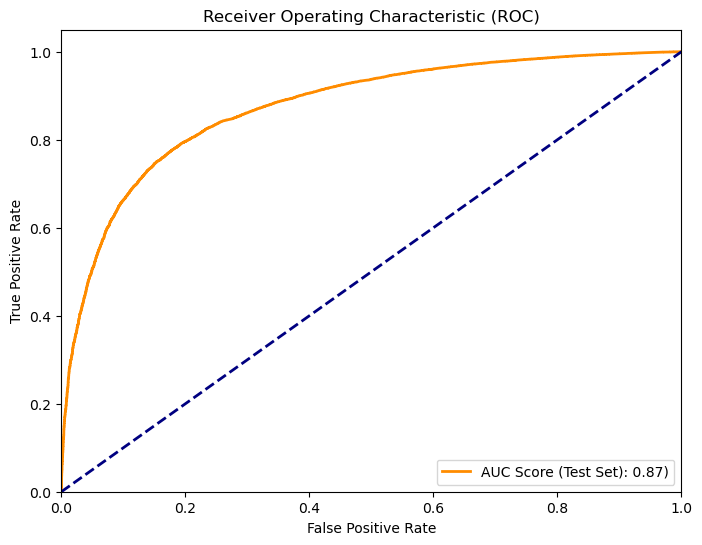

In [22]:
# Plot (Confusion matrix -> test set)
matrix = confusion_matrix(y_test_target_numpy, classification_2)
plt.figure(figsize=(5, 4))
var = sns.heatmap(matrix, annot=True, fmt="d", xticklabels=["Class: 0", "Class: 1"], yticklabels=["Class: 0", "Class: 1"])
var.xaxis.set_label_position("top")
plt.gca().xaxis.tick_top()
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix (test set)")
plt.show()

# Classification Report (test set)
print("Classification report (test set):\n", classification_report(y_test_target_numpy, classification_2, target_names=["Class: 0", "Class: 1"]))

# Plot (ROC-AUC -> test set)
roc_auc = roc_auc_score(y_test_target_numpy, prediction_2)
fpr, tpr, thresholds = roc_curve(y_test_target_numpy, prediction_2) # calculate the roc curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC Score (Test Set): {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# Task 1: Logistic Regression

## Dataprocessing

### Picking a Target

- After having a look at the data columns the Reviewer_Score becomes the natural target value and we create a histogram to have a look at the distribution of scores.

### Preparing data

1. First we create a group based on Hotel_Name to prevent data leakage. This makes sure that a given hotel is only in the training set, or the validation set, not in both.
2. Then we remove Hotel_Address, Hotel_Name, Additional_Number_of_Scoring, lng and lat since they presumably have a high correlation with Average_Score, though I ran out of memory and kept crashing when trying to calculate their correlation.
3. Further we remove Review_Date since I don't see the value in it besides showing how a value prediction might fluctuate over time.
4. I wanted to include tags but they drastically increased my wall time, and a lot of the keywords used are repeated a lot which might reduce their usefulness in identifying the true score.
5. Preparation of Review text columns:
    1. Firstly we remove the "No Negative/Positive" text which can be found in the Negative_Review/Positive_Review columns if they contain no review.
    2. Secondly we combine the Negative_Review and Positive_Review into one text column. The reason for this choice is because running them seperate drastically increased my wall time whilst not yielding any increase in score. A drawback with combining them is that you can't learn two different coefficients for the same word.

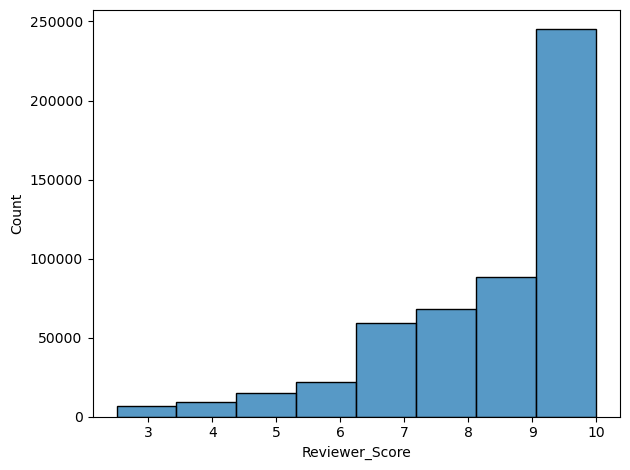

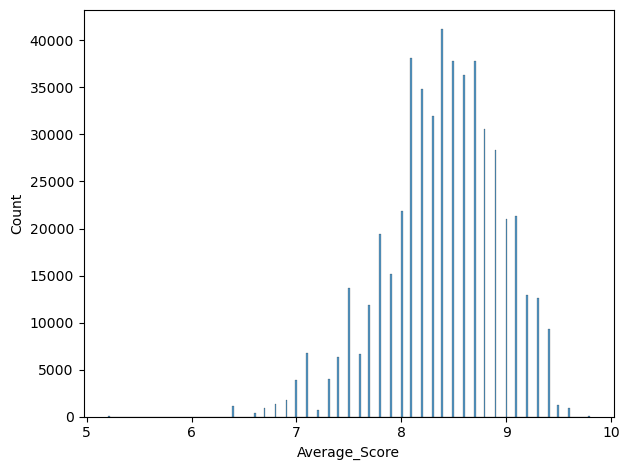

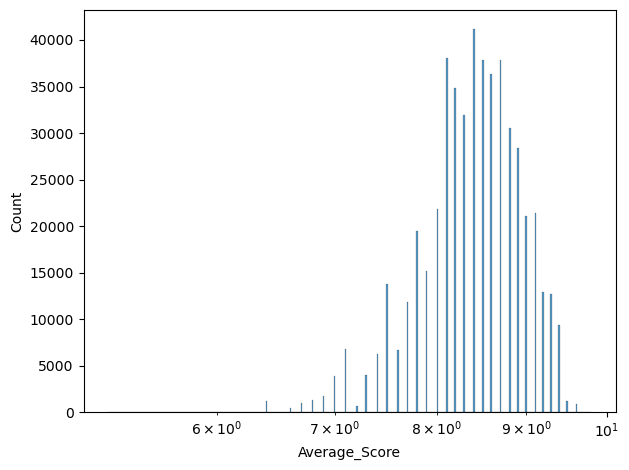

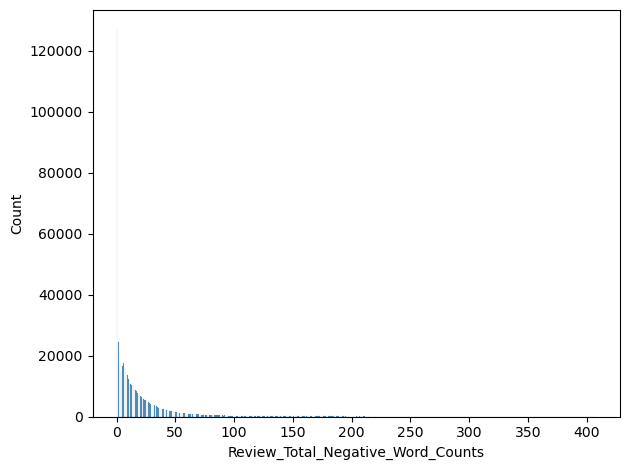

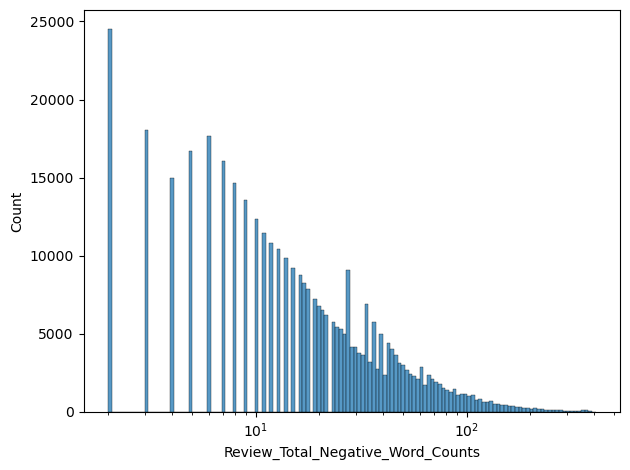

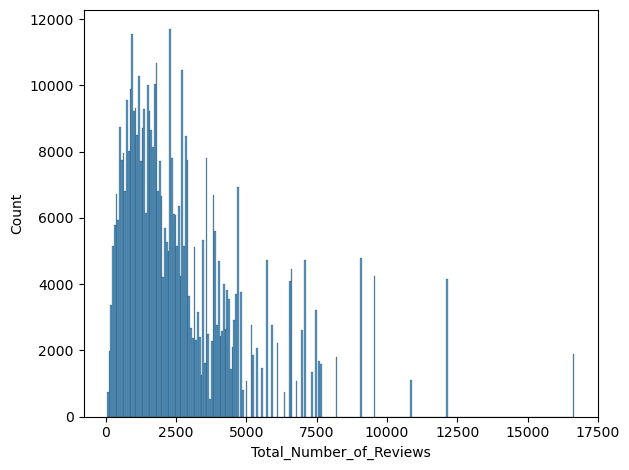

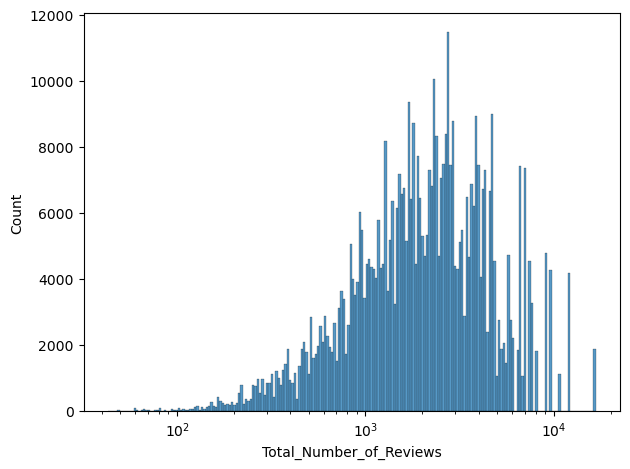

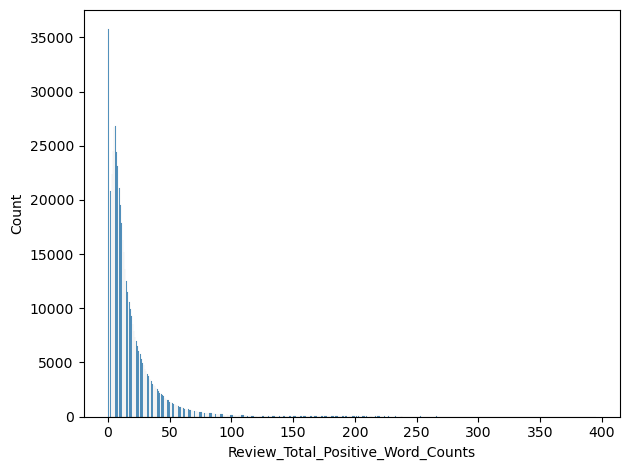

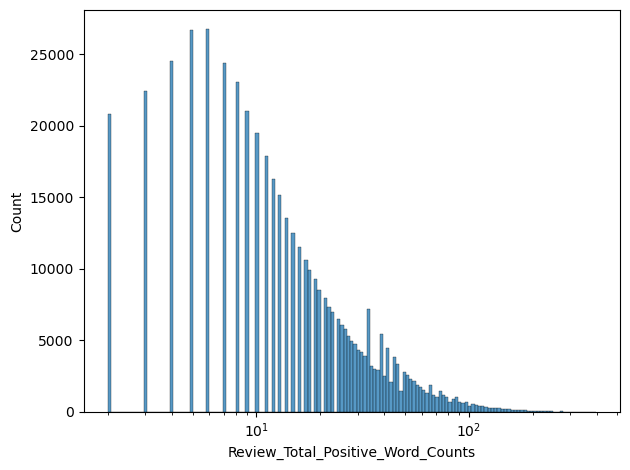

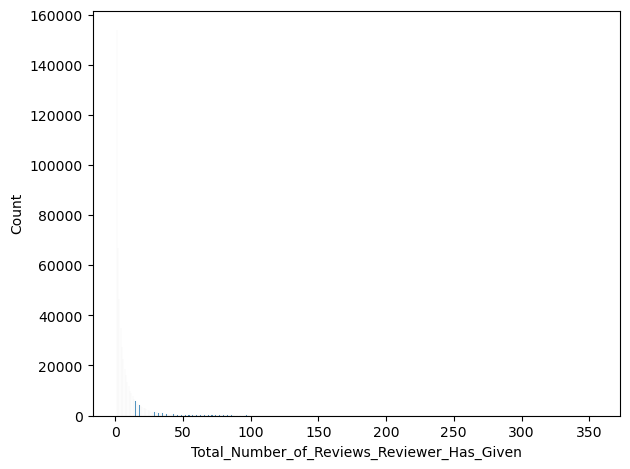

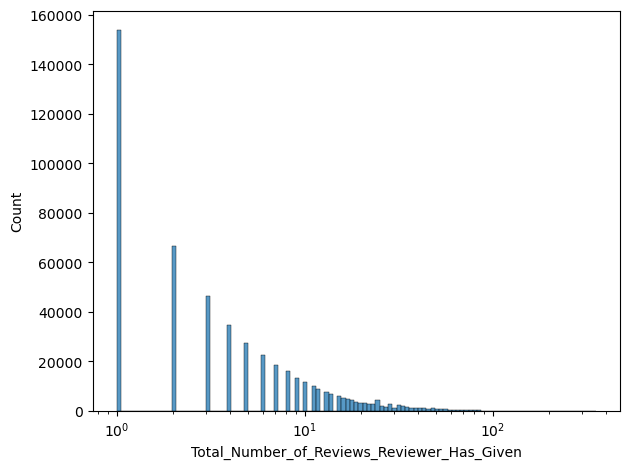

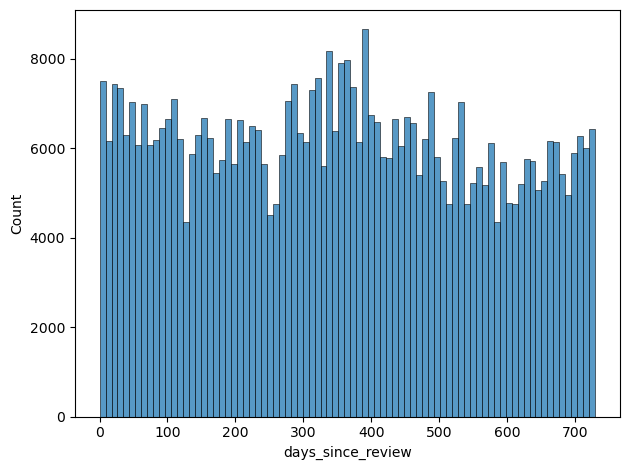

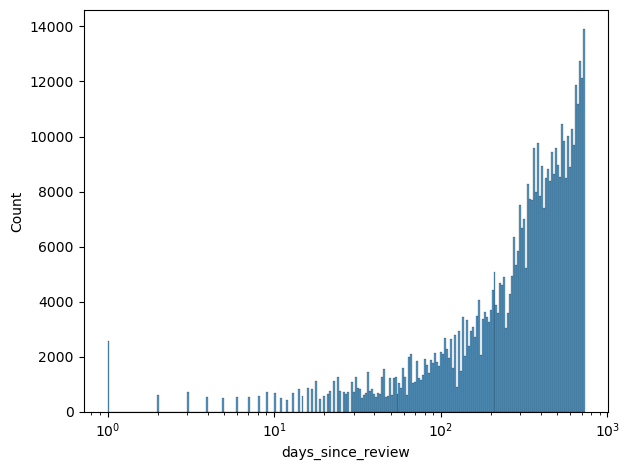

In [23]:
df = pd.read_csv("Hotel_Reviews.csv")
df = df.dropna(how="any", ignore_index=True)
sns.histplot(data=df, x="Reviewer_Score", bins=8)
plt.tight_layout()
plt.show()
# Maps scores equal or above 5.5 to High, else Low
df.Reviewer_Score = np.where(df.Reviewer_Score >= 5.5, "High", "Low")
# Remove the target labels from the main dataset so that we don't accidentally leak any data.
df_sentiment = df.pop("Reviewer_Score")
# Remove unwanted columns
df.pop("Hotel_Address")
# Create grouping
groups = df.Hotel_Name.values
df.pop("Hotel_Name")
df.pop("Additional_Number_of_Scoring")
df.pop("lng")
df.pop("lat")
df.pop("Review_Date")
df.pop("Tags")

# Remove default text that appears if a review has no positive/negative text.
df.Negative_Review = df.Negative_Review.replace(to_replace="^No Negative$", value="", regex=True)
df.Positive_Review = df.Positive_Review.replace(to_replace="^No Positive$", value="", regex=True)
# Remove "days" from column so that we can use its numerical value
df.days_since_review = df.days_since_review.replace(to_replace=" days?$", value="", regex=True).astype(int)
df["Text"] = df.pop("Negative_Review") + " " + df.pop("Positive_Review")
# Split data into training, and testing
X_train, X_test, y_train, y_test, groups_train, _ = train_test_split(df, df_sentiment, groups, random_state=0)

# Visualize distribution of values for continuous values both unscaled and scaled
for column in df:
  if df[column].dtype == "int64" or df[column].dtype == "float64":
    sns.histplot(data=df, x=column, log_scale=False)
    plt.tight_layout()
    plt.show()
    sns.histplot(data=df, x=column, log_scale=True)
    plt.tight_layout()
    plt.show()

## Training the model

1. Here we use ColumnTransformer, as it allows us to transform and scale the data by specifying which columns are to be processed by which transformer instead of seperating the text, categories and numerical values.
2. With Tfidf I have set that a token must appear in at least 5 columns so that possible typos are less likely to be included, I also set a max_df of 75% so that very frequently and basic words which give us little meaning are also removed. Then I set a max_feature of 10.000 so that less meaningful tokens are removed to speed up my model.
3. Having a pipeline where we do the fitting and transforming is important to prevent data leakage during cross-validation. I chose weights instead of under/over-sampling since those methods drastically increased the wall time without any significant gains. We also changed scoring to roc_auc as it can be a better scoring system instead of the default accuracy which can be quite misleading with an imbalanced dataset. I previously searched over multiple parameters to find the best combination, I cut the search out and just used the best parameters to cut down run time. Having a bigger ngram-range always lead to higher score for me, and value of 1 in regularization often performed best.

In [24]:
%%time
nlp = spacy.load("en_core_web_sm", enable=["tokenizer", "lemmatizer", "tagger", "attribute_ruler"])
# Tokenizer combined with stopwords-list
def spacy_tokenizer(text):
    return [token.lemma_ for token in nlp(text)
            if not (token.is_stop or
                    token.is_space or
                    token.like_num)]
# ColumnTransformer allows us to specify which columns are to be transformed by which method inside a pipeline
ct = ColumnTransformer(

    [("text", TfidfVectorizer(tokenizer=spacy_tokenizer, token_pattern=None, min_df=5, max_df=0.75, max_features=10000), "Text"),
     # Scale numerical column logarithmically to make column appear more normally distributed
      ("logRescale", FunctionTransformer(np.log, feature_names_out="one-to-one"), ["Total_Number_of_Reviews"]),
     # Use StandardScaler on columns that appear normally distributed
      ("standardNum", StandardScaler(), ["Average_Score", "Total_Number_of_Reviews"]),
     # On non-Gaussian numerical columns we use MinMaxScaler
      ("minmaxNum", MinMaxScaler(), ["Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "days_since_review"]),
     # Use OneHotEncoder on categorical columns
      ("cat", OneHotEncoder(handle_unknown="ignore"), ["Reviewer_Nationality"])])
pipe = Pipeline([("ct",ct), ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced"))])
param_grid = {"logreg__C": [1], "ct__text__ngram_range": [(1, 3)]}
cv = StratifiedGroupKFold()
grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, scoring="roc_auc")
grid.fit(X_train, y_train, groups=groups_train)

CPU times: user 3min 36s, sys: 2.89 s, total: 3min 39s
Wall time: 13min 1s


GridSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(max_df=0.75,
                                                                                         max_features=10000,
                                                                                         min_df=5,
                                                                                         token_pattern=None,
                                                                                         tokenizer=<function spacy_tokenizer at 0x160565260>),
                                                                         'Text'),
                                                                        ('logRescale',
                                                                         FunctionTransformer(feature_names_out='one-to-one'...
                                                                         ['Review_Total_Negative_Word_Counts',
                                                                          'Review_Total_Positive_Word_Counts',
                                                                          'Total_Number_of_Reviews_Reviewer_Has_Given',
                                                                          'days_since_review']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Reviewer_Nationality'])])),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'ct__text__ngram_range': [(1, 3)], 'logreg__C': [1]},
             scoring='roc_auc')

## Evaluation

- We can see a slight drop in score on the test set compared to the training set, but I'd say that it is so close that overfitting really isn't an issue with the current iteration.

- A roc_auc score of 0.92 for the test set tells us that our model has done a good job in learning how to identify the Low label. An area under the curve of 1.00 would be a perfect prediction and could indicate data leakage, whilst a score of 0.50 would be the same as flipping a coin to determine the label.

In [25]:
y_pred = grid.predict(X_test)
roc_pred_train = grid.decision_function(X_train)
roc_pred_test = grid.decision_function(X_test)

print(f"Best cross-validation score, auc: {roc_auc_score(y_train, roc_pred_train):.2f}, accuracy: {accuracy_score(y_train, grid.predict(X_train)):.2f}")
print(f"y test score auc: {roc_auc_score(y_test, roc_pred_test):.2f}, accuracy: {accuracy_score(y_test, y_pred):.2f}")

Best cross-validation score, auc: 0.94, accuracy: 0.86
y test score auc: 0.92, accuracy: 0.85


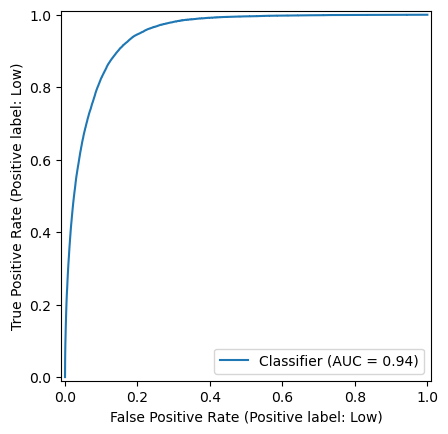

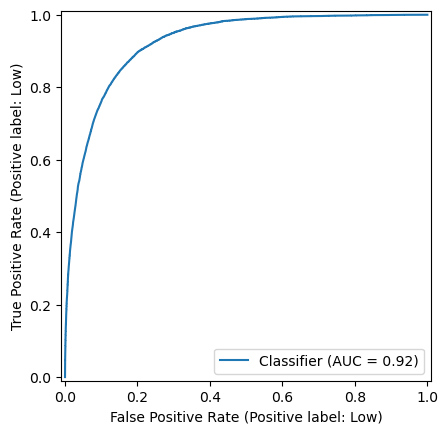

In [26]:
display = RocCurveDisplay.from_predictions(y_train, roc_pred_train, pos_label="Low")
display = RocCurveDisplay.from_predictions(y_test, roc_pred_test, pos_label="Low")

### Classification Report

- The Low category has quite a low precision, which is to be expected when the dataset is imbalanced and I prioritize recall. Here we can see that the current model attempts to guess Low a lot, so much so that any randomly picked Low prediction is more likely to have a true High label than a Low label.

              precision    recall  f1-score   support

        High       0.98      0.85      0.91    118032
         Low       0.33      0.84      0.47     10086

    accuracy                           0.85    128118
   macro avg       0.66      0.85      0.69    128118
weighted avg       0.93      0.85      0.88    128118



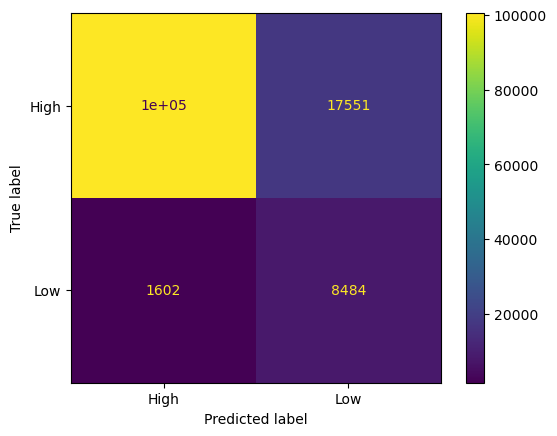

In [27]:
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Top features

- First graph shows the features our model  has determined to be the best features, and from the looks of it I think our model has done a good job in identifying good features.
- Second graph shows the best 3-grams, and here we can see the model did a less good job. Such as the best 3-gram in red being "location location location". I am also able to quite easily identify 3-grams that I would have classified as mislabelled.

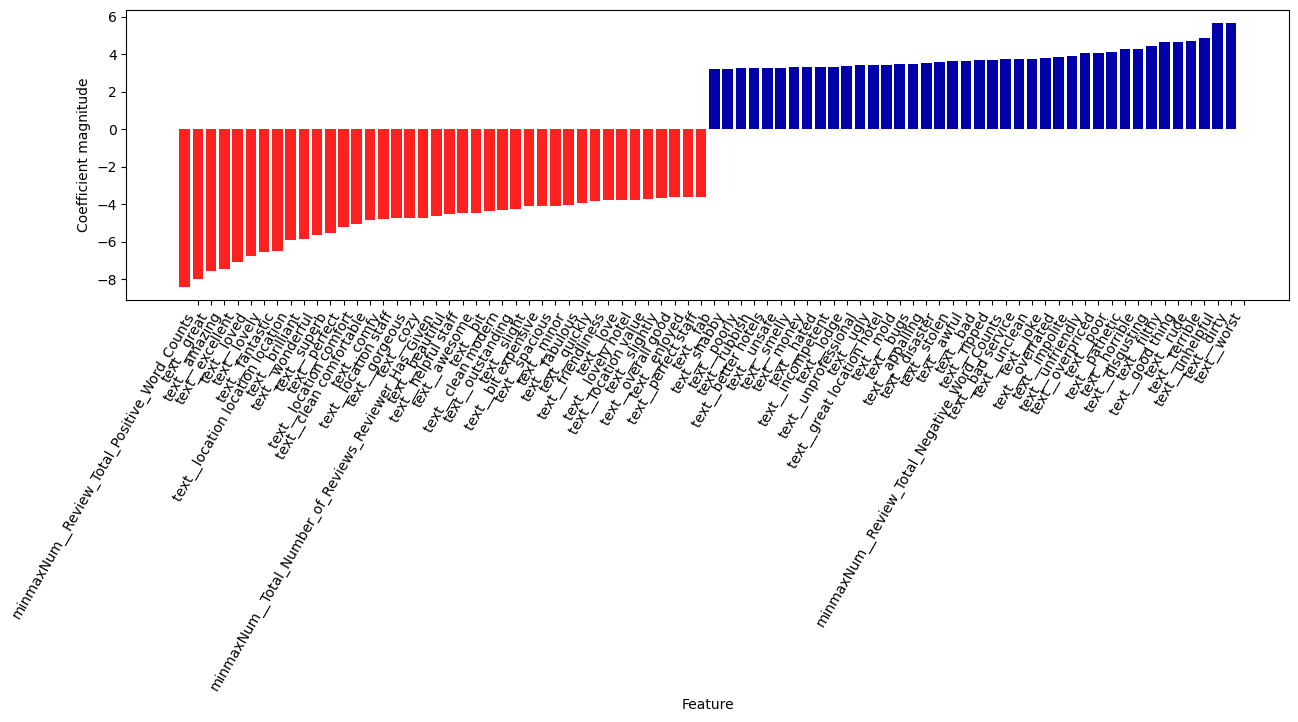

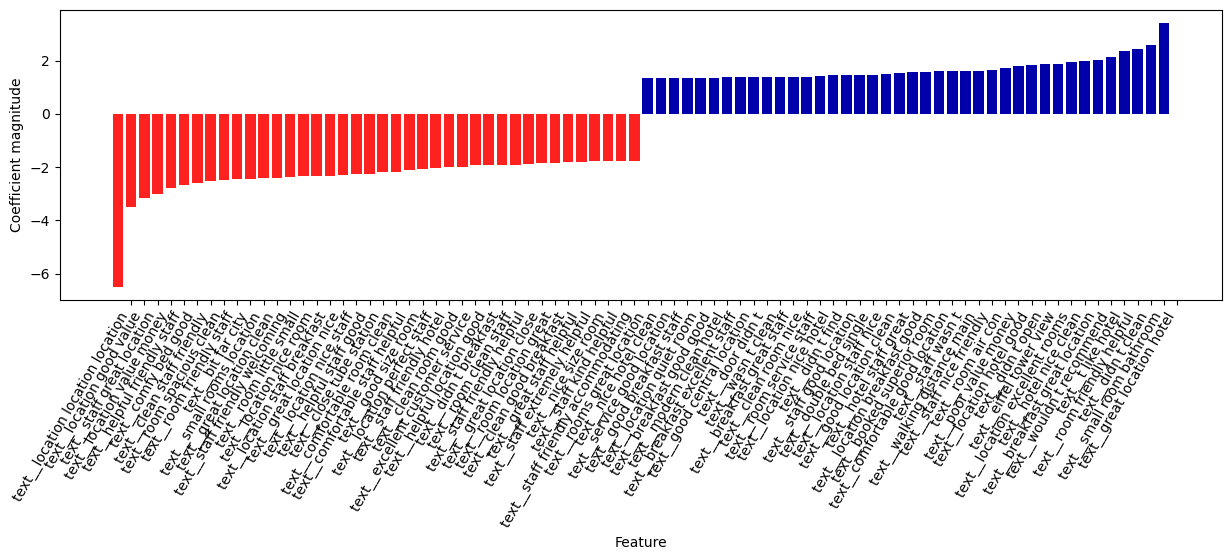

In [28]:
# Both code snippets are taken from Figure 7-4 and 7-5 respectively in Introduction to Machine Learning with Python by by Andreas C. Müller and Sarah Guido
# Display most important features based on how big their coefficient is
vect = grid.best_estimator_.named_steps["ct"]
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps["logreg"].coef_[0]
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

# find 3-gram text features
mask = np.array([len(feature.split()) if feature.startswith("text__") else False for feature in feature_names]) == 3
# visualize best 3-gram text features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
feature_names[mask], n_top_features=40)

# Task 1: Random Forest

In [2]:
df = pd.read_csv('Hotel_Reviews.csv')

#print(df.head())
print(df.info())
#print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

103 k reviews. highly imbalanced (∼4.4 % negative, ∼17.6 % neutral, ∼78 % positive)


I remove everything except for Negative_Review, Positive_Review and Total_Score. This is the bare minimum needed to train the model. But i believe that for this simple assignment it was not necessary to keep other data which can be used to find other patterns in the data. Since the goal is to understand sentiment of the text.

In [3]:
df = df.drop(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', 'Total_Number_of_Reviews', 'Tags', 'days_since_review', 'lat', 'lng', 'Review_Total_Negative_Word_Counts', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given'], axis=1)
#I drop everyone exept 'Negative_Review', 'Positive_Review' and 'Reviewer_Score'
#So just the text, and Reviewer score as a "guide" to check up against if the model is "correct"
#Also there are possibilty to take more columns as input to se if reviews change based on diffrent attributes, but since we only want to find out the sentiment of text/review i dont keep those

print(df.info()) #Checks if columns were keept and removed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Negative_Review  515738 non-null  object 
 1   Positive_Review  515738 non-null  object 
 2   Reviewer_Score   515738 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.8+ MB
None


Here i set a sentiment_score to evaluate the model, we as a group set 5.5 out of 1-10  as the center, therefore the natural point for splitting scores into bad & good. This is used to decide if the model's outcome is "correct". This is again a simple way to decide what is good & bad, but since there were different viewpoints on what would be the "Correct" criteria, we all compromised on 5.5.

I combined positive & negative into a "complete" whole review. to make the

In [4]:
def sentiment_score(score):#checks user score and assings sentiment if above/under a set score
    if score >= 5.5: #7.5 since people often say 7 when they dont care and dont want to critize
        return 'positive'
    elif score < 5.5: #4.9 since everything under 5 is negative
        return 'negative'
    #else: #between 4.9 to 7.5 is neutral. since not positive nor negative
        #return 'neutral'

df['Sentiment'] = df['Reviewer_Score'].apply(sentiment_score)

df['Full_Review'] = df['Positive_Review'] + " " + df['Negative_Review'] #make review whole again, since the module want to take raw input text and be abel to work with "real" text that often has positive and negative intermixed.


Use TF-IDF to downweight very common words (“the”, “hotel”), cap at 5000 tokens to reduce noise and speed up RF training


In [5]:
#Initialize bag of word vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

#Fit and transform the review text
X = vectorizer.fit_transform(df['Full_Review'])

#Convert sentiment labels to numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment'])
#Negative = 0, Neutral = 1, Positive = 2

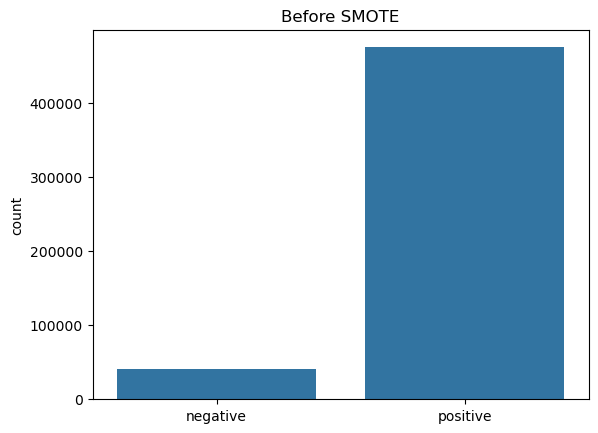

In [6]:
#Before SMOTE
sns.countplot(x = label_encoder.inverse_transform(y))
plt.title("Before SMOTE")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#set random_state to a spesific value to dont get slight diffrent results each time. Ensures reproducibility

I went for the SMOTE solution where i created more of the under-represented set (Negativ) to balance out. I chose this since i did not want to cut the number of positive reviews & get very little data to work with. And did not choose to giving more weight to solve the underfitting, since the data on negative reviews were so low. SMOTE corrects the imbalance so the model learns negative patterns, not just the majority class.

SMOTE applied before train_test_split to ensure both train/test contain balanced classes


In [8]:
#SMOTE after training split to not leak data
#SMOTE to balance datasett (Solution i choose: produce more of under-represented)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

0    475509
1    475509
Name: count, dtype: int64


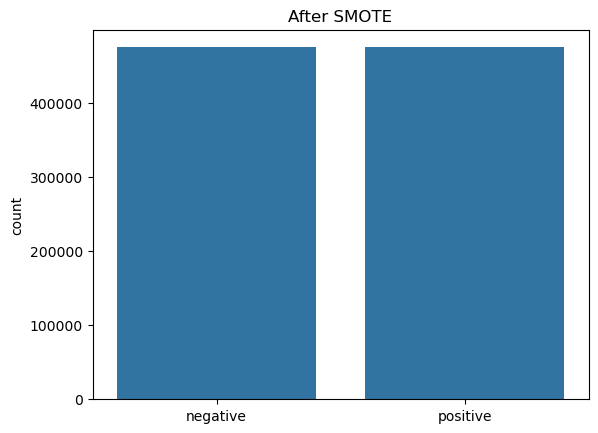

In [9]:
#To show the new class distrubution
print(pd.Series(y_resampled).value_counts())

#After SMOTE
sns.countplot(x = label_encoder.inverse_transform(y_resampled))
plt.title("After SMOTE")
plt.show()

Random Forest chosen for robustness to noisy text features and ability to report feature importances

n_estimators=50 balances accuracy vs. training time on a laptop. Higher is better, but slower.

random_state=42 ensures reproducible splits and tree randomness. Can be removed

In [10]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
#n_estimators = Number of Trees, Higher = More trees -> More robust predictions, but slower. & vice versa.
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

feature importance shows a small set of word carry most of the predictive power for sentiment. This shows that e.g. positive is a key term to distinguish positive from negative reviews. Most words contribute almost nothing.

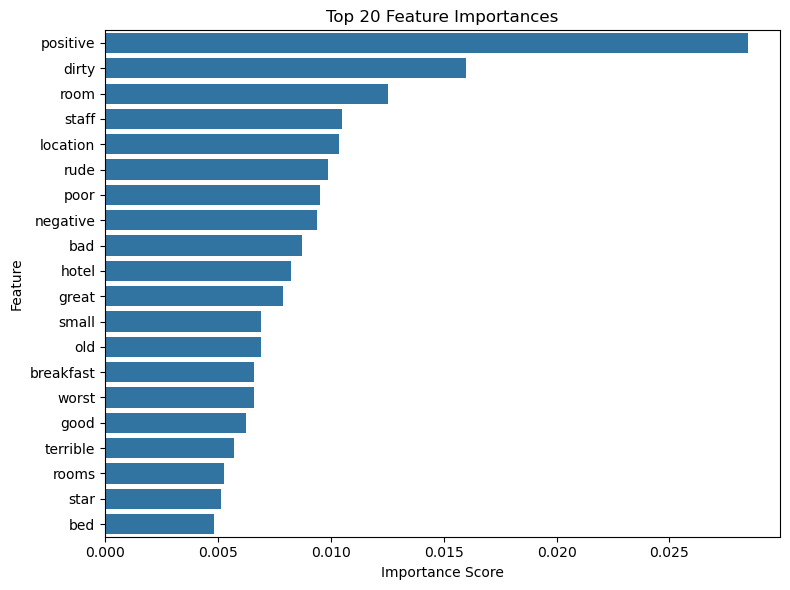

In [11]:
#Feature Importance
feature_importances = rf_model.feature_importances_

feature_names = vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values('Importance', ascending=False)

#Limit to only top 20 features
top_n = 20
top_features = importance_df.nlargest(top_n, 'Importance')

plt.figure(figsize=(8, 6))  #wider/taller diagram
sns.barplot(x='Importance', y='Feature', data=top_features, orient='h')
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()  #avoid label cutoff
plt.show()

In [12]:
#Predictions
y_pred = rf_model.predict(X_test)

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9254760150463411

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.10      0.18      8179
           1       0.93      1.00      0.96     94969

    accuracy                           0.93    103148
   macro avg       0.82      0.55      0.57    103148
weighted avg       0.91      0.93      0.90    103148



The 2×2 confusion matrix shows the model correctly flags almost all positive reviews (94 474/94 969 ≈ 99.5% recall) but only catches about 1 004 of 8 179 actual negatives (≈ 12.3% recall), misclassifying most negatives as positive. This is unsurprising given the class imbalance and the crude 5.5 score cutoff—many mildly negative texts end up labeled “positive,” adding noise to the minority class.

Severe Class Imbalance – Negative samples are only ~4 % of the data, so even with SMOTE the model sees far fewer genuine negatives and tends to favor the majority class.

Label Noise from Thresholding – Using a single numeric cutoff (e.g. score < 6) lumps mildly negative or mixed‐tone reviews into “negative,” even if the text reads fairly neutral or positive, confusing the classifier.

Feature Representation Limits – A bag-of-words TF-IDF ignores word order and nuance (e.g., sarcasm or negation like “not bad”), making it hard to detect subtle negativity.

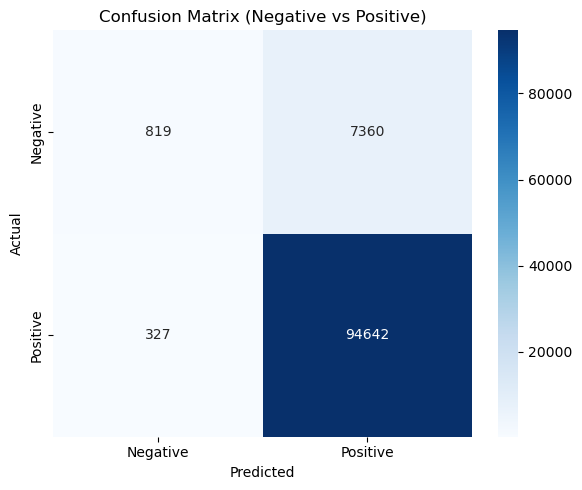

              precision    recall  f1-score   support

    Negative       0.71      0.10      0.18      8179
    Positive       0.93      1.00      0.96     94969

    accuracy                           0.93    103148
   macro avg       0.82      0.55      0.57    103148
weighted avg       0.91      0.93      0.90    103148



In [13]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Negative vs Positive)')
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Task 1: Naive Bayes

The model predicts hotel review scores using binary classification, based on numerical and text data. Complement Naive Bayes was chosen because it handles imbalanced, high-dimensional text data efficiently.

## Preprocessing (Naive Bayes)

  1. Feature selection:
        1. text_columns was chosen as its crucial data for the model. The model also performs well with text.
        2. number_columns was included as it does provide useful information.
        
  2. Feature engineering:
        1. TF-IDF is used with text_columns as ML models work better with numbers, and we reduce dimensionality by limiting the alphabet to 2000 and removing english stopwords.
        2. MinMaxScaler is used so that values do not go below 0, and is a common way to normalize values. The model can learn more effectively this way.
        3. SMOTE is used (see "COMMON TEXT")

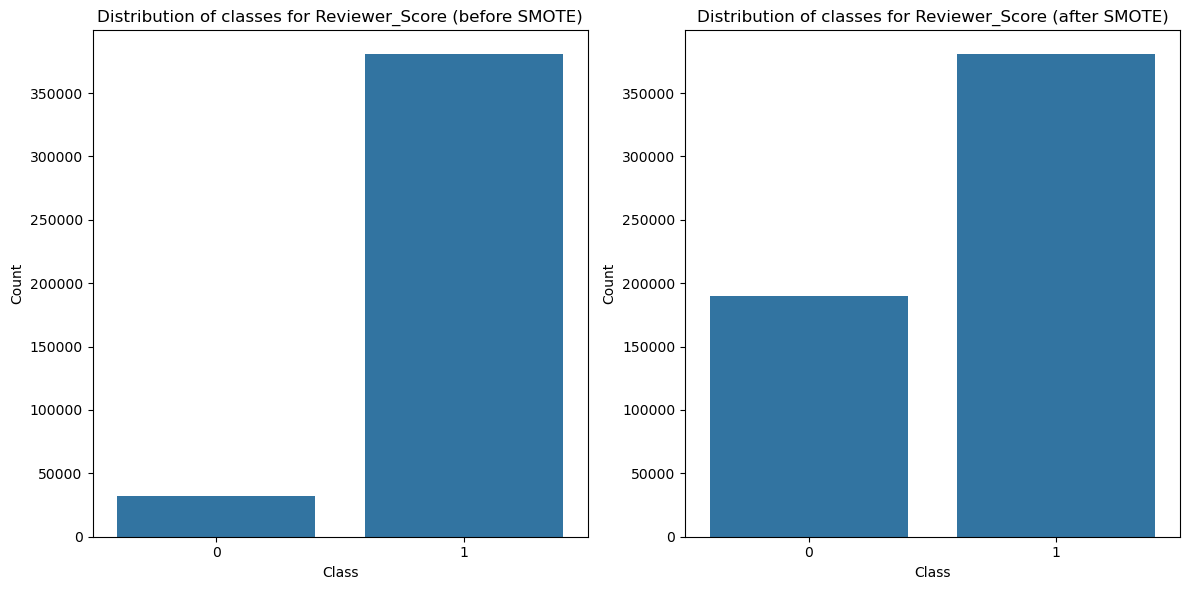

Original dataset shape (some rows might have been dropped): (515738, 6)


In [14]:
path = "Hotel_Reviews.csv"

number_columns = ["Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given"]

text_columns = ["Negative_Review", "Positive_Review"]

target_feature = "Reviewer_Score" # to be predicted in the model

dataset = pd.read_csv(path, usecols=text_columns + number_columns + [target_feature], low_memory=False)

# Converts the values in target_feature to 0 or 1, values greater than 5.5 will be 1, values below 5.5 will be 0
dataset[target_feature] = (dataset[target_feature] >= 5.5).astype("int")

# Converts string values in number_columns to numeric values (float or int)
for column in number_columns:
    dataset[column] = pd.to_numeric(dataset[column], errors="coerce")
dataset.dropna(inplace=True)

# Splitting the dataset into training and test sets
X = dataset.drop(columns=[target_feature])
y = dataset[target_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Text vectorization (no padding, text_columns = ["Negative_Review", "Positive_Review"])
X_train_text = [" ".join(row) for row in X_train[text_columns].astype(str).values]
X_test_text = [" ".join(row) for row in X_test[text_columns].astype(str).values]

vectorizer = TfidfVectorizer(max_features=2000, stop_words="english") # vocabulary size = 2000
X_train_vectorizer = vectorizer.fit_transform(X_train_text)
X_test_vectorizer = vectorizer.transform(X_test_text)

# Convert text columns to Numpy arrays
X_train_text_numpy = X_train_vectorizer.toarray()

# MinMaxScaler (number columns)
scaler = MinMaxScaler()
X_train_number = scaler.fit_transform(X_train[number_columns])
X_test_number = scaler.transform(X_test[number_columns])

# Concatenate columns (text columns + number columns)
X_train_combined = np.hstack([X_train_text_numpy, X_train_number])
X_test_combined = np.hstack([X_test_vectorizer.toarray(), X_test_number])

# Plot variable (before SMOTE)
plot_1 = y_train

# SMOTE (number_columns + text_columns)
smote = SMOTE(random_state=20, sampling_strategy=0.5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train)

# Convert to sparse matrix (number_columns + text_columns, so that the model can handle the data)
X_train_smote_convert = csr_matrix(X_train_smote)
X_test_combined_convert = csr_matrix(X_test_combined)

# Plot variable (after SMOTE)
plot_2 = y_train_smote

# Plot (before and after SMOTE)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=plot_1)
plt.title("Distribution of classes for Reviewer_Score (before SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=plot_2)
plt.title("Distribution of classes for Reviewer_Score (after SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Print shape
print(f"Original dataset shape (some rows might have been dropped): {dataset.shape}")

## Model (Naive Bayes)

1. ComplementNB is the model, which will calculate the weights through statistics.
    1. A default configuration has been used, as changing alpha parameter did not change much.
2. Setting TF-IDF to 2000, using SMOTE and also using ComplementNB will prevent overfitting.
3. For underfitting, enough text should have beeen kept to prevent this.

In [15]:
naive_bayes = ComplementNB()
naive_bayes.fit(X_train_smote_convert, y_train_smote)

# Predictions + classifications (.predict())
prediction_1 = naive_bayes.predict(X_test_combined_convert) # (test set, outputs predicted labels, e.g 0 or 1)

probability_1 = naive_bayes.predict_proba(X_test_combined_convert)[:, 1] # (probabilities for class 1, number between 0 and 1)

# Print model configuration
print(f"Model configuration (parameters): {naive_bayes.get_params()}")

Model configuration (parameters): {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True, 'norm': False}


## Evaluation of the model (Naive Bayes)

1. We focus on F1-score and ROC-AUC, not accuracy. This is because of the class imbalance. An explanation for this can be found in the evaluation part in the LSTM model (nr.2).
2. The classification report shows that class 1 gets high precision and decent recall, while class 0 has a poor precision and decent recall. This means the model performs well on class 1, but because there are very few class 0 data points the precision for class 0 is very low.
3. We also get a low F1-score for class 0 and a decent or high score for class 1. F1-score considers both precision and recall.
4. The metrics show that, despite a high score on distinguishing between classes (high ROC-AUC), the model significantly favors class 1 (the majority class).

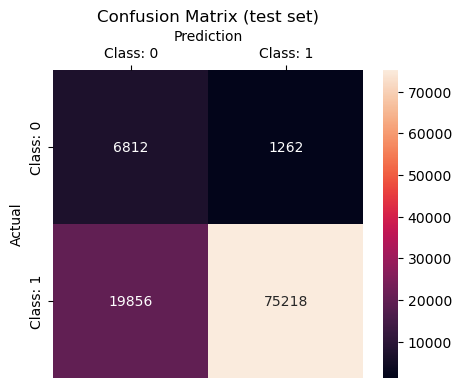

Classification report (test set):
               precision    recall  f1-score   support

    Class: 0       0.26      0.84      0.39      8074
    Class: 1       0.98      0.79      0.88     95074

    accuracy                           0.80    103148
   macro avg       0.62      0.82      0.63    103148
weighted avg       0.93      0.80      0.84    103148



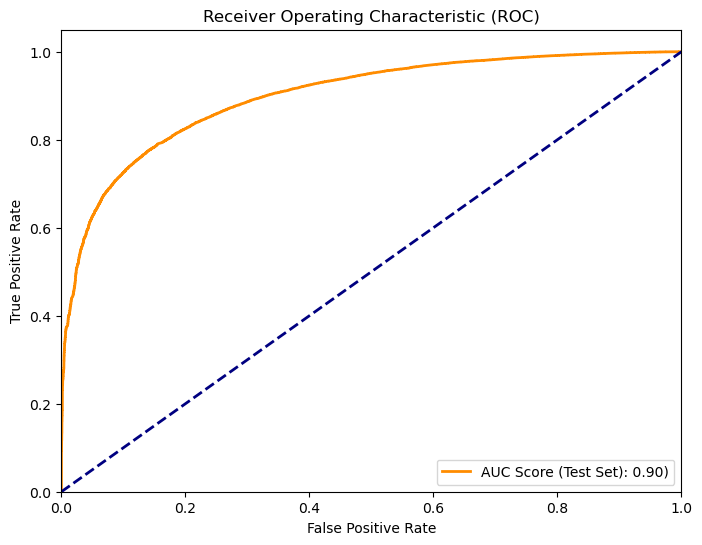

In [16]:
# Plot (Confusion matrix -> test set)
matrix = confusion_matrix(y_test, prediction_1)
plt.figure(figsize=(5, 4))
var = sns.heatmap(matrix, annot=True, fmt="d", xticklabels=["Class: 0", "Class: 1"], yticklabels=["Class: 0", "Class: 1"])
var.xaxis.set_label_position("top")
plt.gca().xaxis.tick_top()
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix (test set)")
plt.show()

# Classification Report (test set)
print("Classification report (test set):\n", classification_report(y_test, prediction_1, target_names=["Class: 0", "Class: 1"]))

# Plot (ROC-AUC -> test set)
roc_auc = roc_auc_score(y_test, probability_1)
fpr, tpr, thresholds = roc_curve(y_test, probability_1) # calculate the roc curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC Score (Test Set): {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# Task 2: CNN

This is a custom CNN model (using TensorFlow) for binary classification of airplanes in the CIFAR-10 dataset, where the chosen label is airplane (1).

## Preprocessing (CNN)

1. After making this into a binary classification problem with two classes (0 and 1), the airplane images in the CIFAR-10 dataset will only be 1/10 of the images and the rest 9/10. The problem is therefore imbalanced.
2. Airplanes are converted to 1, and all other to 0.
3. The images are normalized, which is something that usually should be done. It can make the model train more efficiently.

Training set shape: (50000, 32, 32, 3)
Testing set shape: (10000, 32, 32, 3)
Total number of labels: 50000
Total number of labels: 10000
Image shape: (32, 32, 3)


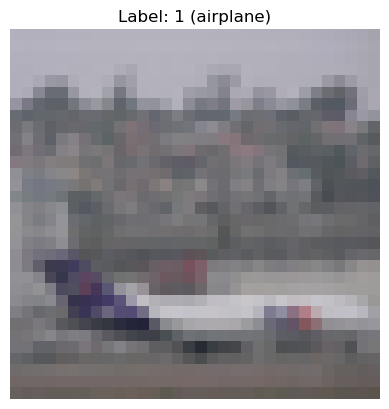

In [17]:
# Load the dataset (CIFAR-10), returns four Numpy arrays
# (TensorFlow, 2024). See REFERENCE 1 (and section "Download and prepare the CIFAR10 dataset") in last section from where the code (loading of dataset) has been adapted from
(x_train_img, y_train_label), (x_test_img, y_test_label) = tf.keras.datasets.cifar10.load_data()

all_classes = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

target_feature = 0 # "airplane" is chosen as our target label/what we want to predict

# Convert labels to 0 and 1 for target_feature. If a label == target_features label then it is set to 1, otherwise it is 0
y_train_label = (y_train_label == target_feature).astype("int")
y_test_label = (y_test_label == target_feature).astype("int")

# Normalize pixel values to be between 0 and 1 (usually something that should be done, but there are alternatives)
# (TensorFlow, 2024). See REFERENCE 1 (and section "Download and prepare the CIFAR10 dataset") in last section from where the code has been adapted from
x_train_img = x_train_img / 255.0
x_test_img = x_test_img / 255.0

# Shape (number of images (samples), height of image, width of image, RGB (e.g number of channels, greyscale has 1 channel))
print(f"Training set shape: {x_train_img.shape}")
print(f"Testing set shape: {x_test_img.shape}")

# Total number of labels (50 000 number of images above and 50 000 labels here)
print(f"Total number of labels: {len(y_train_label)}")
print(f"Total number of labels: {len(y_test_label)}")

# Image shape + plot of image
image = x_train_img[30000] # image and label must match
label = y_train_label[30000][0] # y_train_label[0] is a 2D array, with [0][0] we get the label

print(f"Image shape: {image.shape}") # shape of the image (which also is the three last numbers in x_train_img.shape)

plt.imshow(image)
plt.title(f"Label: {label} ({'airplane' if label == 1 else 'not airplane'})")
plt.axis("off")
plt.show()

## Model (CNN)

1. Architecture:
   1. One convolutional layer (32 filters), and then MaxPooling2D. This is a common pattern for CNN.
   2. Dropout layer is used to prevent overfitting.
   3. The tensors are then flattened, and then sent into a hidden layer (64 neurons) with relu activation function (non-linearity).
   4. We use sigmoid activation function which has one output for a binary classification problem.
2. Training:
   1. We chose 6 external images to get more information (compared to 1).
   2. Weights are used to rebalance the dataset so that class 1 becomes more important in the model. This prevents overfitting for class 0.
   3. EarlyStopping is used to stop training earlier if the loss on the validation set stops improving for 3 epochs in a row, then we restore the best weights. This prevents overfitting.

Epoch 1/32
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - AUC: 0.7912 - loss: 2.0120e-05 - val_AUC: 0.8974 - val_loss: 0.4646
Epoch 2/32
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - AUC: 0.8882 - loss: 1.5816e-05 - val_AUC: 0.9220 - val_loss: 0.3949
Epoch 3/32
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - AUC: 0.9147 - loss: 1.3783e-05 - val_AUC: 0.9296 - val_loss: 0.3244
Epoch 4/32
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - AUC: 0.9252 - loss: 1.2841e-05 - val_AUC: 0.9375 - val_loss: 0.3218
Epoch 5/32
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - AUC: 0.9376 - loss: 1.1813e-05 - val_AUC: 0.9393 - val_loss: 0.2910
Epoch 6/32
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - AUC: 0.9423 - loss: 1.1339e-05 - val_AUC: 0.9406 - val_loss: 0.4356
Epoch 7/32
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - AUC: 0.9520 - loss: 1.0457e-05 - val_AUC: 0.9437 - val_loss: 0.2264
Epoch 8/32
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - AUC: 0.9595 - loss: 9.5419e-06 - val_AUC: 0.9389 - val_loss: 0.318

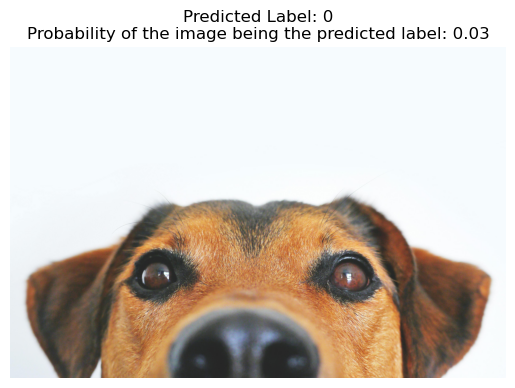

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


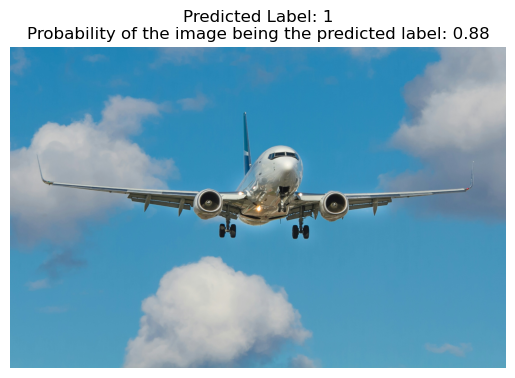

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


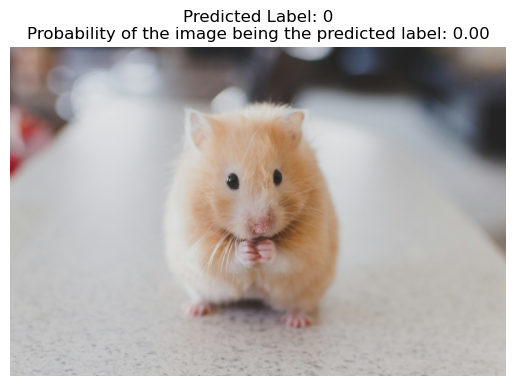

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


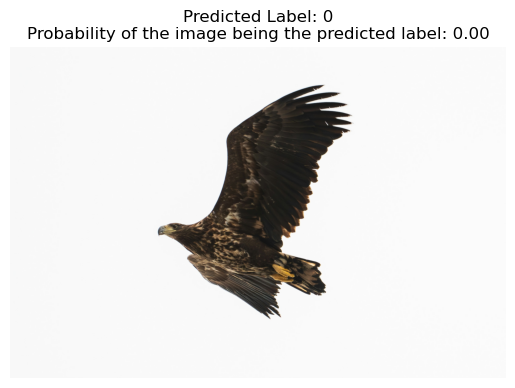

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


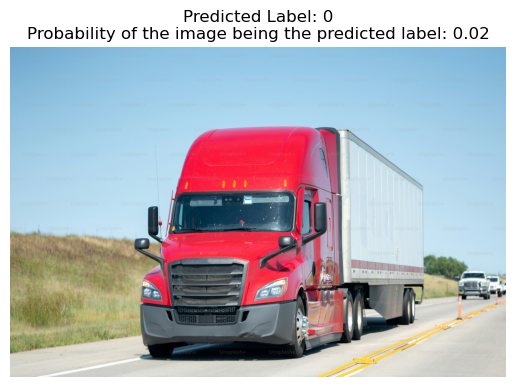

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


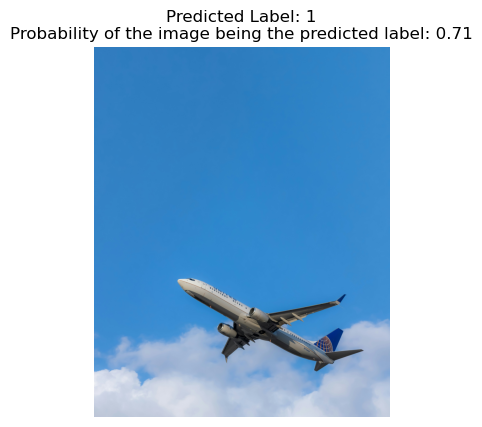

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385,477 (5.29 MB)

 Trainable params: 461,825 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 923,652 (3.52 MB)

None


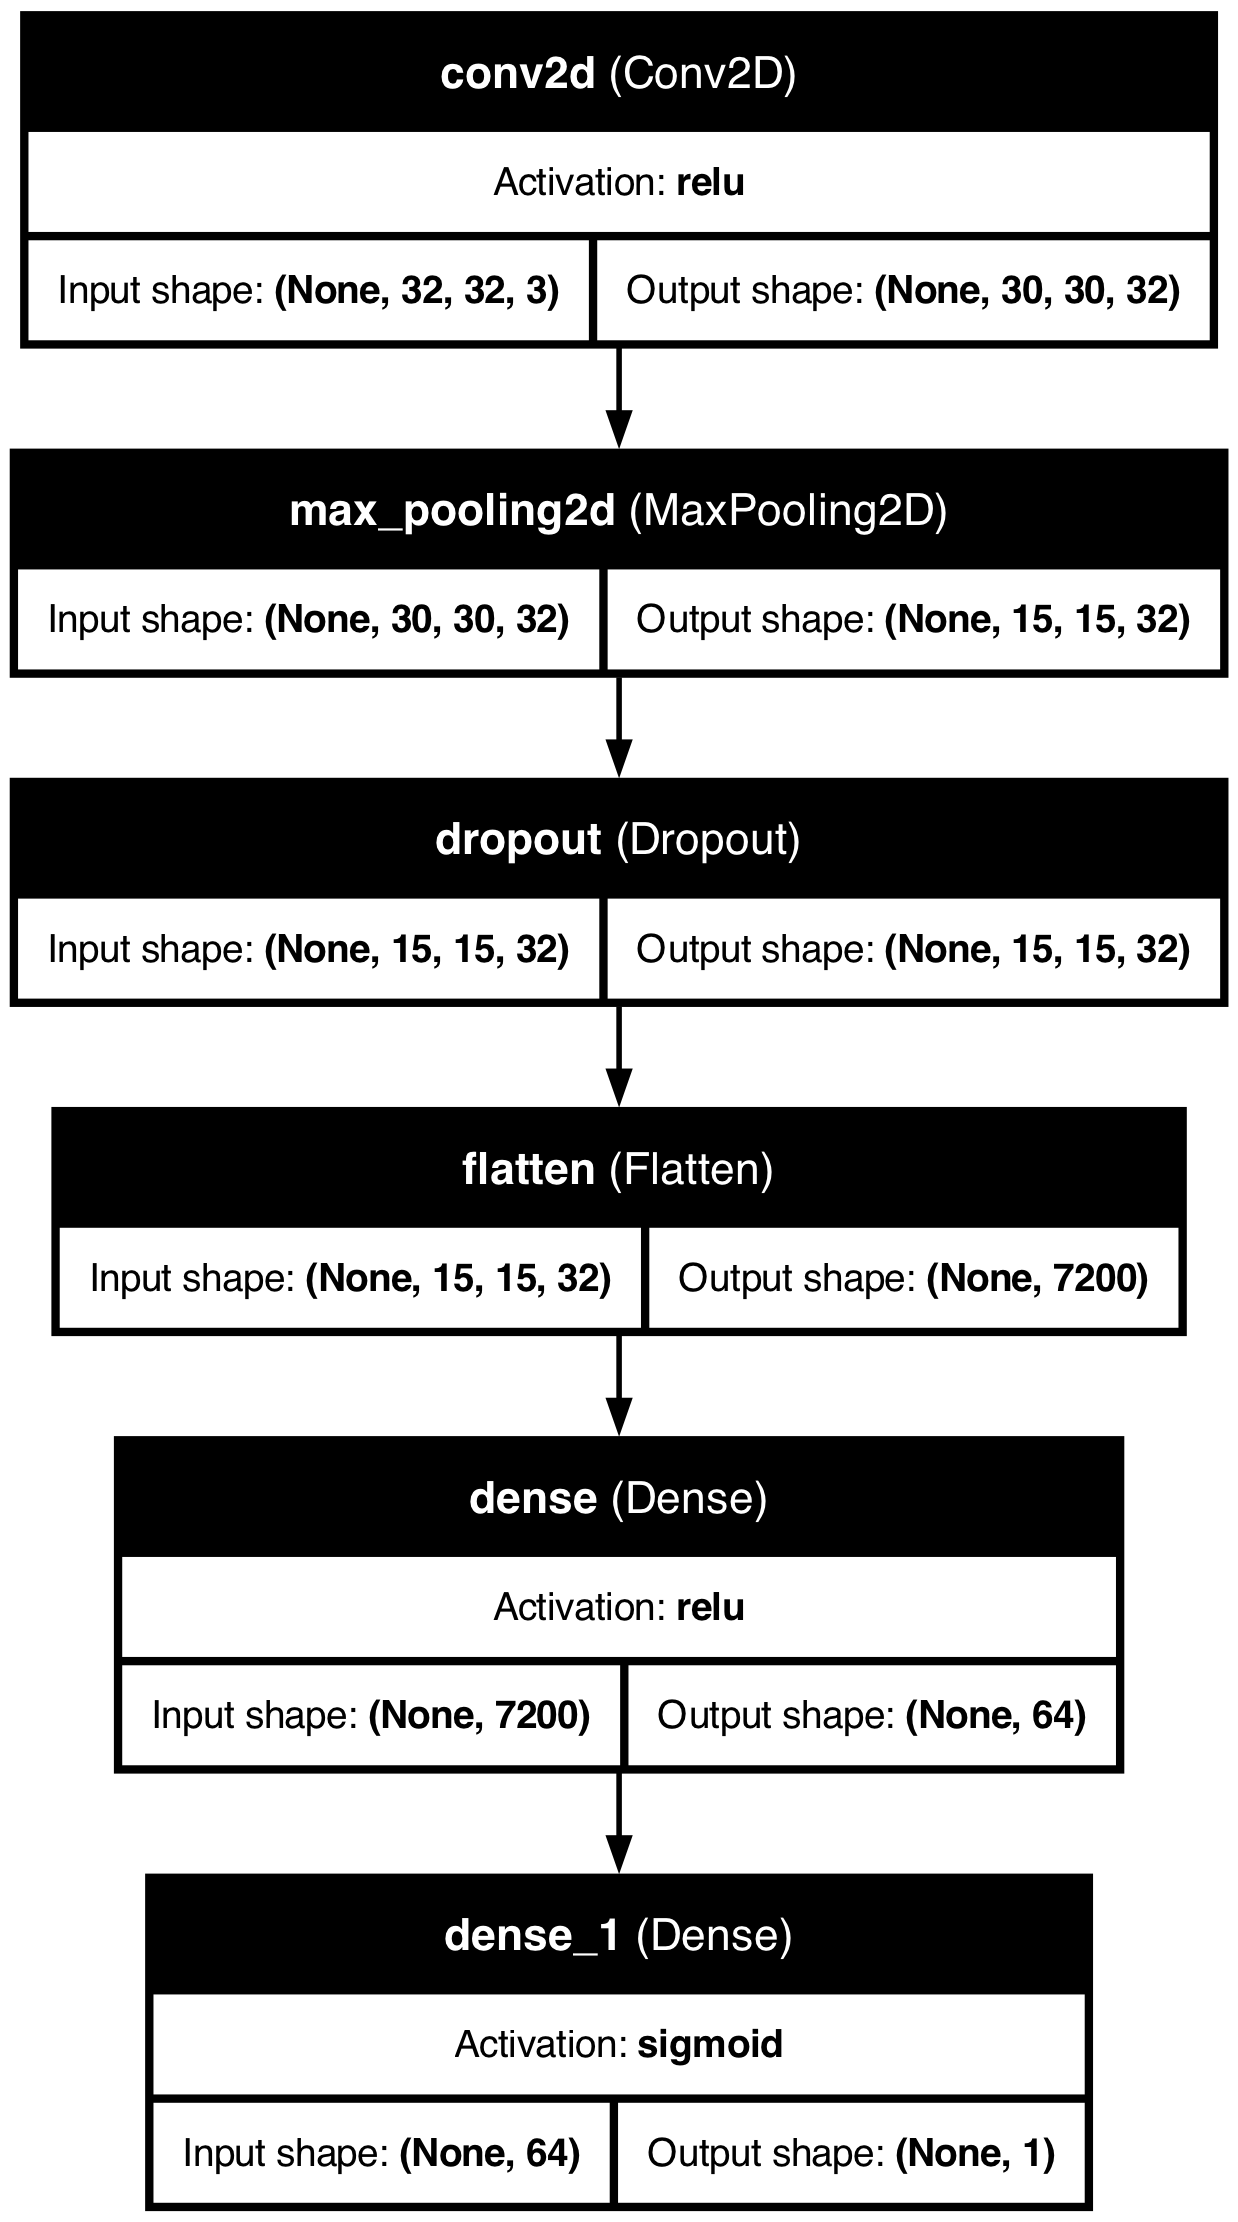

In [18]:
# Custom CNN (which takes the CIFAR-10 images)
cnn = models.Sequential()
cnn.add(Input(shape=(32, 32, 3)))

cnn.add(layers.Conv2D(32, (3, 3), activation="relu"))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Dropout(0.5))


cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation="relu"))
cnn.add(layers.Dense(1, activation="sigmoid")) # Sigmoid for binary classification

cnn.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["AUC"])

# Train the model
cnn.fit(
    x_train_img, y_train_label,
    epochs=32,
    class_weight = {0:1/44000, 1:1/6000}, # Add more weight to "airplane" (class 1), because it is only 6000 images
    callbacks = EarlyStopping(patience=3, restore_best_weights=True), # Stops training after 2 epochs if it does not improve anymore
    validation_data=(x_test_img, y_test_label)
    )

# Predict labels for the test set
predicted_labels_test_set = cnn.predict(x_test_img)
predicted_labels_test_set = [1 if prediction[0] > 0.5 else 0 for prediction in predicted_labels_test_set]

# Function to handle external images from URL
def external_image(img_url):
    img = Image.open(requests.get(img_url, stream=True).raw) # open image from URL
    img = img.resize((32, 32)) # resize it to correct image size
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0) # Add batch, so that the model can handle the image (which means it becomes a 4D array with shape (1, 32, 32, 3))
    return img

image_urls = [
    # picture of a dog
    "https://images.pexels.com/photos/406014/pexels-photo-406014.jpeg",
    # picture of an airplane
    "https://images.unsplash.com/photo-1569629743817-70d8db6c323b",
    # picture of a hamster
    "https://images.unsplash.com/photo-1425082661705-1834bfd09dca",
    # picture of an eagle
    "https://images.unsplash.com/photo-1740214845705-04a20e2e22c1",
    # picture of a truck
    "https://plus.unsplash.com/premium_photo-1664695368767-c42483a0bda1",
    # picture of an airplane
    "https://images.unsplash.com/photo-1559268950-2d7ceb2efa3a"
]

# Predict labels for external URLs
predicted_labels = [] # stores predictions for external images

for image_url in image_urls:
    external_img = external_image(image_url)
    prediction = cnn.predict(external_img)

    # Converts probability to a label (1 or 0)
    predicted_label = 1 if prediction[0][0] > 0.5 else 0
    predicted_labels.append(predicted_label)

    # Display the image
    img = Image.open(requests.get(image_url, stream=True).raw)
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_label}\nProbability of the image being the predicted label: {prediction[0][0]:.2f}")
    plt.axis("off")
    plt.show()

# Summary + plot of architecture
print(cnn.summary())
plot_model(cnn,
           show_shapes=True,
           show_layer_names=True,
           show_layer_activations=True,
           expand_nested=True)

## Evaluation of the model (CNN)

1. Precision, recall, F1-score and ROC-AUC are important metrics for this model, as the problem is imbalanced. We evaluate the model on the 6 external images and the test set, as the test set can give us a better idea of how the model is actually performing.
2. The classification report for the external images show a very high score, which we can connect to there being very few of these images.
3. The test set gets a high ROC-AUC score, meaning it is good at distinguishing between class 0 and 1. It gets a high precision for class 0 and lower for class 1 (airplane). Both class 0 and 1 get high recall, meaning most instances of each class is classified. F1-score for class 0 is high. The F1-score for class 1 is lower as it makes more incorrect classifications, lowering the precision and therefore the F1-score.

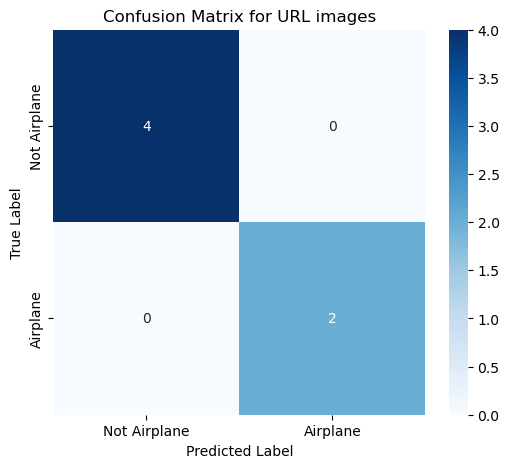

Classification report (external URLs):
               precision    recall  f1-score   support

Not Airplane       1.00      1.00      1.00         4
    Airplane       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



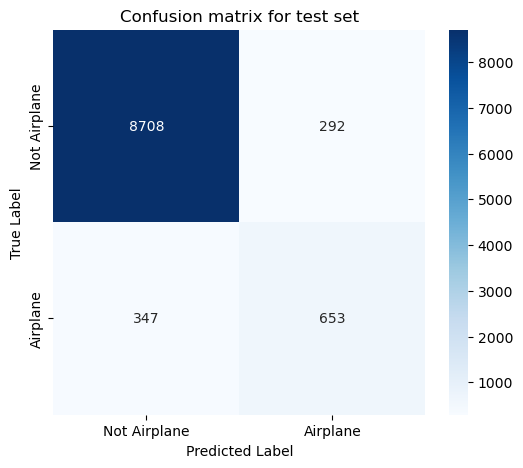

Classification report (test set):
               precision    recall  f1-score   support

Not Airplane       0.96      0.97      0.96      9000
    Airplane       0.69      0.65      0.67      1000

    accuracy                           0.94     10000
   macro avg       0.83      0.81      0.82     10000
weighted avg       0.93      0.94      0.94     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


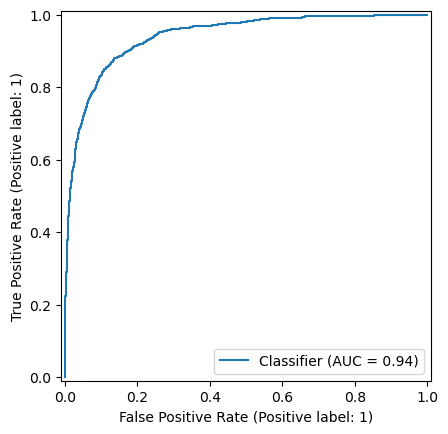

In [19]:
# Labels for external Images, 0 = "Not Airplane", 1 = "Airplane"
actual_labels = [0, 1, 0, 0, 0, 1]

# Accuracy (external URLs + test set)
accuracy_test_set = accuracy_score(y_test_label, predicted_labels_test_set)
accuracy_external = accuracy_score(actual_labels, predicted_labels)

# Plot (Confusion matrix -> external images)
confusion = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Airplane", "Airplane"], yticklabels=["Not Airplane", "Airplane"])
plt.title("Confusion Matrix for URL images")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report (external images)
print("Classification report (external URLs):\n", classification_report(actual_labels, predicted_labels, target_names=["Not Airplane", "Airplane"]))

# Plot (Confusion matrix -> test set)
confusion_test = confusion_matrix(y_test_label, predicted_labels_test_set)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Airplane", "Airplane"], yticklabels=["Not Airplane", "Airplane"])
plt.title("Confusion matrix for test set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report (test set)
print("Classification report (test set):\n", classification_report(y_test_label, predicted_labels_test_set, target_names=["Not Airplane", "Airplane"]))

# ROC-curve (test set)
RocCurveDisplay.from_predictions(y_test_label, cnn.predict(x_test_img), pos_label=1)

# Summary

For task 1, instead of combining all the steps and choices we make we have decided on keeping them separated so that the group's individual ideas and decisions are kept and we are free to approach the problem differently. This has lead to differences in every step, for example, we select different features, have different preprocessing steps, and pick different parameters. This has lead to some varying priorities and results. An example of this is the priority of logistic regression, LSTM, and Naive Bayes which achieves a good recall for the negative/low sentiment. So choices such as changing the scorer to ROC-AUC was made, and consequences such as a low precision for the given label occurred. Whilst Random Forest emphasizes high precision using its default accuracy scorer, it also leverages SMOTE similar to LSTM and Naive Bayes. By aggregating many randomized decision trees, it captures complex non-linear interactions, reduces overfitting through ensemble voting, and remains efficient to train on a laptop. Its built-in feature-importance metrics provide clear interpretability that deep models lack. In contrast, Logistic Regression and Naive Bayes are simplistic “batteries-included” methods requiring careful feature scaling and independence assumptions; LSTM excels at sequential text patterns but demands extensive preprocessing (tokenization, padding, embeddings) and more computational resources. All models perform well on abundant positive reviews, but balancing techniques are crucial to improve performance on the minority negative class.

Task 2 had quite good results, the model predicted all external images perfectly. For the test set it had a precision of 0.69, and a recall of 0.65 for the selected minority label. While there is some obvious room for improvement in the score, we have created a model from scratch that manages to capture the essence of identifying airplanes quite well while keeping a simple structure(generalization). Which is quite useful since it is faster to train, and a more complex model would overfit more easily. The model also utilizes weights, normalization, dropout and early stopping to combat the imbalance and reduce overfitting.

# References

1. TensorFlow. (2024, 16. august). *Convolutional Neural Network (CNN)*. TensorFlow Core. https://www.tensorflow.org/tutorials/images/cnn